### Imports

In [68]:
import pandas as pd
import datetime as dt

matches = pd.read_csv("matches.csv", index_col=0)

### Data Cleaning and Feature Engineering

In [69]:
matches.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
1,15/08/2021,16:30,Premier League,Matchweek 1,Sun,Away,L,0,1,Tottenham,...,Match Report,NaN,18,4,16.9,1,0,0,2022,Manchester City
2,21/08/2021,15:00,Premier League,Matchweek 2,Sat,Home,W,5,0,Norwich City,...,Match Report,NaN,16,4,17.3,1,0,0,2022,Manchester City
3,28/08/2021,12:30,Premier League,Matchweek 3,Sat,Home,W,5,0,Arsenal,...,Match Report,NaN,25,10,14.3,0,0,0,2022,Manchester City
4,11/09/2021,15:00,Premier League,Matchweek 4,Sat,Away,W,1,0,Leicester City,...,Match Report,NaN,25,8,14.0,0,0,0,2022,Manchester City
6,18/09/2021,15:00,Premier League,Matchweek 5,Sat,Home,D,0,0,Southampton,...,Match Report,NaN,16,1,15.7,1,0,0,2022,Manchester City


In [70]:
matches.columns

Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation',
       'referee', 'match report', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk',
       'pkatt', 'season', 'team'],
      dtype='object')

In [71]:
matches.drop(["round", 
              "comp", 
              "season", 
              "attendance", 
              "notes", 
              "captain", 
              "formation", 
              "referee", 
              "match report", 
              "notes"], 
             axis=1, inplace=True)

In [72]:
matches["team"].value_counts()

Manchester United           72
Southampton                 72
West Ham United             72
Newcastle United            72
Brighton and Hove Albion    72
Wolverhampton Wanderers     71
Tottenham Hotspur           71
Burnley                     71
Leeds United                71
Arsenal                     71
Manchester City             71
Crystal Palace              71
Everton                     70
Chelsea                     70
Aston Villa                 70
Leicester City              70
Sheffield United            38
West Bromwich Albion        38
Fulham                      38
Liverpool                   38
Brentford                   34
Watford                     33
Norwich City                33
Name: team, dtype: int64

In [73]:
matches["date"] = pd.to_datetime(matches["date"])

In [74]:
matches["venue_code"] = matches["venue"].astype("category").cat.codes

In [75]:
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype(int)

In [76]:
matches["day_code"] = matches["date"].dt.dayofweek

In [77]:
class MissingDict(dict):
    __missing__ = lambda self, key: key
    
map_values = {  
    "Brighton and Hove Albion": "Brighton",
    "Manchester United": "Manchester Utd",
    "Newcastle United": "Newcastle Utd",
    "Sheffield United": "Sheffield Utd",
    "Tottenham Hotspur": "Tottenham",
    "West Bromwich Albion": "West Brom",
    "West Ham United": "West Ham",
    "Wolverhampton Wanderers": "Wolves",    
}
mapping = MissingDict(**map_values)

In [78]:
matches['team'] = matches['team'].map(mapping)

In [79]:
matches.head()

,date,time,day,venue,result,gf,ga,opponent,xg,xga,...,sh,sot,dist,fk,pk,pkatt,team,venue_code,hour,day_code
1,2021-08-15,16:30,Sun,Away,L,0,1,Tottenham,1.9,1.3,...,18,4,16.9,1,0,0,Manchester City,0,16,6
2,2021-08-21,15:00,Sat,Home,W,5,0,Norwich City,2.7,0.1,...,16,4,17.3,1,0,0,Manchester City,1,15,5
3,2021-08-28,12:30,Sat,Home,W,5,0,Arsenal,3.8,0.1,...,25,10,14.3,0,0,0,Manchester City,1,12,5
4,2021-11-09,15:00,Sat,Away,W,1,0,Leicester City,2.9,0.8,...,25,8,14.0,0,0,0,Manchester City,0,15,1
6,2021-09-18,15:00,Sat,Home,D,0,0,Southampton,1.1,0.4,...,16,1,15.7,1,0,0,Manchester City,1,15,5


In [80]:
#determine points acquired
matches["points"] = matches["result"].apply(lambda row: 3 if row=="W" else 1 if row=="D" else 0)

In [81]:
matches.columns

Index(['date', 'time', 'day', 'venue', 'result', 'gf', 'ga', 'opponent', 'xg',
       'xga', 'poss', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'team',
       'venue_code', 'hour', 'day_code', 'points'],
      dtype='object')

In [82]:
matches.sort_values('date', inplace=True)

In [83]:
cols = ['points', 'gf', 'ga', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'poss', 'xg', 'xga']
new_cols = [f"{c}_rolling" for c in cols]

In [84]:
matches[new_cols] = matches.groupby('team')[cols].transform(lambda x: x.rolling(4).mean().shift().bfill())

In [85]:
grp_matches = matches.groupby("team").apply(lambda a: a[:]).drop('team', axis=1).droplevel(1)

In [86]:
grp_matches.reset_index(inplace=True)

In [87]:
avg_matches = grp_matches[['date', 
                           'team',
                           'opponent',
                           'venue_code', 
                           'hour', 
                           'day_code', 
                           'points_rolling', 
                           'gf_rolling', 
                           'ga_rolling', 
                           'sh_rolling', 
                           'sot_rolling', 
                           'dist_rolling', 
                           'fk_rolling', 
                           'pk_rolling', 
                           'pkatt_rolling',
                           'poss_rolling',
                           'xg_rolling', 
                           'xga_rolling', 
                           'points']].dropna(axis=0)

In [88]:
home_matches = avg_matches[avg_matches["venue_code"]==1].sort_values("date")
away_matches = avg_matches[avg_matches["venue_code"]==0].sort_values("date")

In [89]:
home_matches.head()

,date,team,opponent,venue_code,hour,day_code,points_rolling,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,poss_rolling,xg_rolling,xga_rolling,points
1104,2020-01-11,Tottenham,Brighton,1,19,5,3.00,2.75,0.50,13.50,4.25,17.425,1.00,0.50,0.50,49.25,1.925,0.725,3
889,2020-01-11,Newcastle Utd,Everton,1,14,5,1.50,1.25,1.75,7.00,2.25,17.400,0.25,0.50,0.50,42.75,1.375,1.075,3
817,2020-01-11,Manchester Utd,Arsenal,1,16,5,1.50,1.75,2.25,10.25,3.50,20.150,0.50,0.25,0.25,49.00,1.175,1.925,0
71,2020-01-11,Aston Villa,Southampton,1,12,5,2.25,3.50,1.50,17.75,6.75,15.125,0.25,0.25,0.25,50.50,2.100,1.225,0
567,2020-02-11,Leeds United,Leicester City,1,20,1,0.25,1.00,3.00,10.25,4.50,15.600,0.25,0.00,0.00,59.25,1.200,2.400,0


In [90]:
away_matches.head()

,date,team,opponent,venue_code,hour,day_code,points_rolling,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,poss_rolling,xg_rolling,xga_rolling,points
0,2020-01-11,Arsenal,Manchester Utd,0,16,5,1.50,0.75,1.5,9.25,2.50,17.525,0.25,0.25,0.25,59.00,0.950,0.675,3
175,2020-01-11,Brighton,Tottenham,0,19,5,0.25,1.00,2.0,11.75,2.75,16.175,0.50,0.25,0.25,55.25,1.250,1.250,0
459,2020-01-11,Everton,Newcastle Utd,0,14,5,1.00,1.75,2.0,11.50,4.25,16.775,0.00,0.00,0.00,55.00,1.325,1.525,0
1032,2020-01-11,Southampton,Aston Villa,0,12,5,3.00,2.50,1.0,11.50,5.00,17.825,0.50,0.25,0.25,54.50,0.975,1.125,3
1208,2020-02-11,West Brom,Fulham,0,17,1,0.00,0.25,2.5,9.00,2.50,18.675,0.25,0.00,0.00,45.50,0.550,1.525,0


In [91]:
merge_matches = pd.merge(home_matches, away_matches, 
                         left_on=["date", "team", "opponent"], 
                         right_on=["date", "opponent", "team"], 
                         suffixes=('_home', '_away')).sort_values("date")

In [92]:
merge_matches.drop(["opponent_home", "opponent_away", "venue_code_home", "venue_code_away", "points_away", "hour_away", "day_code_away"], axis=1, inplace=True)

In [93]:
merge_matches.columns

Index(['date', 'team_home', 'hour_home', 'day_code_home',
       'points_rolling_home', 'gf_rolling_home', 'ga_rolling_home',
       'sh_rolling_home', 'sot_rolling_home', 'dist_rolling_home',
       'fk_rolling_home', 'pk_rolling_home', 'pkatt_rolling_home',
       'poss_rolling_home', 'xg_rolling_home', 'xga_rolling_home',
       'points_home', 'team_away', 'points_rolling_away', 'gf_rolling_away',
       'ga_rolling_away', 'sh_rolling_away', 'sot_rolling_away',
       'dist_rolling_away', 'fk_rolling_away', 'pk_rolling_away',
       'pkatt_rolling_away', 'poss_rolling_away', 'xg_rolling_away',
       'xga_rolling_away'],
      dtype='object')

In [94]:
merge_matches.rename({"hour_home": "hour", "day_code_home": "day_code"}, axis=1, inplace=True)

In [95]:
merge_matches.columns

Index(['date', 'team_home', 'hour', 'day_code', 'points_rolling_home',
       'gf_rolling_home', 'ga_rolling_home', 'sh_rolling_home',
       'sot_rolling_home', 'dist_rolling_home', 'fk_rolling_home',
       'pk_rolling_home', 'pkatt_rolling_home', 'poss_rolling_home',
       'xg_rolling_home', 'xga_rolling_home', 'points_home', 'team_away',
       'points_rolling_away', 'gf_rolling_away', 'ga_rolling_away',
       'sh_rolling_away', 'sot_rolling_away', 'dist_rolling_away',
       'fk_rolling_away', 'pk_rolling_away', 'pkatt_rolling_away',
       'poss_rolling_away', 'xg_rolling_away', 'xga_rolling_away'],
      dtype='object')

In [96]:
merge_matches["team_home_code"] = merge_matches["team_home"].astype("category").cat.codes

In [97]:
merge_matches["team_away_code"] = merge_matches["team_away"].astype("category").cat.codes

In [98]:
# create columns with average stat differences between the two teams

merge_matches['points_rolling_diff'] = (merge_matches['points_rolling_home']-merge_matches['points_rolling_away'])
merge_matches['gf_rolling_diff'] = (merge_matches['gf_rolling_home']-merge_matches['gf_rolling_away'])
merge_matches['ga_rolling_diff'] = (merge_matches['ga_rolling_home']-merge_matches['ga_rolling_away'])
merge_matches['sh_rolling_diff'] = (merge_matches['sh_rolling_home']-merge_matches['sh_rolling_away'])
merge_matches['sot_rolling_diff'] = (merge_matches['sot_rolling_home']-merge_matches['sot_rolling_away'])
merge_matches['poss_rolling_diff'] = (merge_matches['poss_rolling_home']-merge_matches['poss_rolling_away'])
merge_matches['xg_rolling_diff'] = (merge_matches['xg_rolling_home']-merge_matches['xg_rolling_away'])
merge_matches['xga_rolling_diff'] = (merge_matches['xga_rolling_home']-merge_matches['xga_rolling_away'])

In [99]:
final_df = merge_matches[['date',
                          'hour', 
                          'day_code', 
                          'team_home',
                          'team_away', 
                          'points_rolling_diff', 
                          'gf_rolling_diff', 
                          'ga_rolling_diff', 
                          'sh_rolling_diff', 
                          'sot_rolling_diff', 
                          'poss_rolling_diff', 
                          'xg_rolling_diff', 
                          'xga_rolling_diff', 
                          'points_home']]

In [100]:
final_df.corr()['points_home'][:]

hour                   0.017084
day_code              -0.024894
points_rolling_diff    0.278675
gf_rolling_diff        0.273982
ga_rolling_diff       -0.188554
sh_rolling_diff        0.216702
sot_rolling_diff       0.269155
poss_rolling_diff      0.257845
xg_rolling_diff        0.279435
xga_rolling_diff      -0.195818
points_home            1.000000
Name: points_home, dtype: float64

In [113]:
final_df.head()

,date,hour,day_code,team_home,team_away,points_rolling_diff,gf_rolling_diff,ga_rolling_diff,sh_rolling_diff,sot_rolling_diff,poss_rolling_diff,xg_rolling_diff,xga_rolling_diff,points_home
0,2020-01-11,19,5,Tottenham,Brighton,2.75,1.75,-1.50,1.75,1.50,-6.00,0.675,-0.525,3
1,2020-01-11,14,5,Newcastle Utd,Everton,0.50,-0.50,-0.25,-4.50,-2.00,-12.25,0.050,-0.450,3
2,2020-01-11,16,5,Manchester Utd,Arsenal,0.00,1.00,0.75,1.00,1.00,-10.00,0.225,1.250,0
3,2020-01-11,12,5,Aston Villa,Southampton,-0.75,1.00,0.50,6.25,1.75,-4.00,1.125,0.100,0
4,2020-02-11,20,1,Leeds United,Leicester City,-2.00,-0.75,1.75,1.75,1.50,4.00,-0.625,1.550,0


In [121]:
final_df["team_home_code"] = final_df["team_home"].astype("category").cat.codes
final_df["team_away_code"] = final_df["team_away"].astype("category").cat.codes

<ipython-input-121-e774a49b65a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["team_home_code"] = final_df["team_home"].astype("category").cat.codes
<ipython-input-121-e774a49b65a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["team_away_code"] = final_df["team_away"].astype("category").cat.codes


## Machine Learning Model

In [126]:
train = final_df[final_df["date"] < "2022-01-01"].select_dtypes(['number'])

In [127]:
test = final_df[final_df["date"] > "2022-01-01"].select_dtypes(['number'])

In [134]:
train.head()

,hour,day_code,points_rolling_diff,gf_rolling_diff,ga_rolling_diff,sh_rolling_diff,sot_rolling_diff,poss_rolling_diff,xg_rolling_diff,xga_rolling_diff,points_home,team_home_code,team_away_code
0,19,5,2.75,1.75,-1.50,1.75,1.50,-6.00,0.675,-0.525,3,18,3
1,14,5,0.50,-0.50,-0.25,-4.50,-2.00,-12.25,0.050,-0.450,3,14,7
2,16,5,0.00,1.00,0.75,1.00,1.00,-10.00,0.225,1.250,0,13,0
3,12,5,-0.75,1.00,0.50,6.25,1.75,-4.00,1.125,0.100,0,1,17
4,20,1,-2.00,-0.75,1.75,1.75,1.50,4.00,-0.625,1.550,0,9,10


In [135]:
X_train = train.drop("points_home", axis=1)
y_train = train["points_home"]

In [136]:
X_train

,hour,day_code,points_rolling_diff,gf_rolling_diff,ga_rolling_diff,sh_rolling_diff,sot_rolling_diff,poss_rolling_diff,xg_rolling_diff,xga_rolling_diff,team_home_code,team_away_code
0,19,5,2.75,1.75,-1.50,1.75,1.50,-6.00,0.675,-0.525,18,3
1,14,5,0.50,-0.50,-0.25,-4.50,-2.00,-12.25,0.050,-0.450,14,7
2,16,5,0.00,1.00,0.75,1.00,1.00,-10.00,0.225,1.250,13,0
3,12,5,-0.75,1.00,0.50,6.25,1.75,-4.00,1.125,0.100,1,17
4,20,1,-2.00,-0.75,1.75,1.75,1.50,4.00,-0.625,1.550,9,10
...,...,...,...,...,...,...,...,...,...,...,...,...
539,15,1,0.50,1.00,-0.25,-0.50,-0.50,0.25,0.125,0.150,6,15
538,15,1,0.50,0.75,0.25,2.75,1.25,-6.50,0.875,0.300,19,21
541,20,2,-2.00,-3.75,0.50,-11.00,-6.00,-24.50,-2.150,0.100,2,12
542,19,2,0.00,0.50,0.50,-3.00,1.25,11.25,0.775,-0.350,5,3


In [137]:
X_test = test.drop("points_home", axis=1)
y_test = test["points_home"]

In [138]:
import seaborn as sns

<AxesSubplot: xlabel='gf_rolling_diff', ylabel='points_home'>

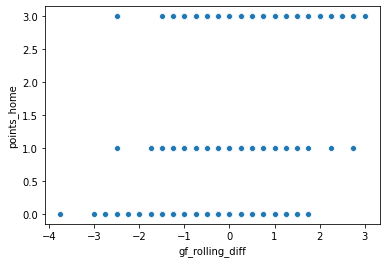

In [140]:
sns.scatterplot(X_train.loc[:,"gf_rolling_diff"], y_train)

### XGBoost

In [141]:
import xgboost as xgb

In [144]:
xgbreg = xgb.XGBRegressor(objective="reg:squarederror", 
                          random_state=42
                         )

In [145]:
xgbreg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [150]:
y_pred = xgbreg.predict(X_test)

In [155]:
len(y_test)

131

In [156]:
len(y_pred)

131

In [189]:
len(X_train.columns)

12

In [158]:
from sklearn.metrics import r2_score

In [159]:
r2_score(y_test, y_pred)

-0.039697704304101133

In [180]:
def objective_xgb(space):
    
    model = xgb.XGBRegressor(objective="reg:squarederror", 
                             max_depth=int(space['max_depth']),
                             min_child_weight=int(space['min_child_weight']),
                             n_estimators=int(space['n_estimators']),
                             eval_metric="rmse",
                             early_stopping_rounds=10,
                             random_state=42
                            )
    
    evaluation=[(X_test, y_test)]
    
    model.fit(X_train, y_train, eval_set=evaluation, verbose=False)
    
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    
    loss = 1 - score
    
    return {'loss': loss, 'status': STATUS_OK, 'model': model}

In [184]:
from hyperopt import hp, Trials, fmin, tpe, STATUS_OK

space={'max_depth': hp.quniform("max_depth", 1, 18, 1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 1000, 1),
       'n_estimators': hp.quniform("n_estimators", 1, 1000, 1)
      }

In [185]:
xgb_trials = Trials()

In [190]:
best_params_xgb = fmin(
    fn=objective_xgb,
    space=space,
    algo=tpe.suggest,
    trials=xgb_trials,
    max_evals=1000)

100%|██████████| 1000/1000 [03:00<00:00,  5.53trial/s, best loss: 0.9100792052904919]


In [191]:
print(best_params_xgb)

{'max_depth': 12.0, 'min_child_weight': 79.0, 'n_estimators': 687.0}


In [195]:
import numpy as np

def getBestModelfromTrials(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['model']

In [196]:
xgb_model = getBestModelfromTrials(xgb_trials)

In [197]:
pred = xgb_model.predict(X_test)

In [203]:
pred_rnd = np.around(pred)

In [208]:
r2_score(y_test, pred_rnd)

0.07366184677828491

In [205]:
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=12, max_leaves=0, min_child_weight=79, missing=nan,
             monotone_constraints='()', n_estimators=687, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)